In [ ]:
!pip install transformers torch datasets transformers[torch]

from google.colab import drive
import pandas as pd
from datasets import Dataset, DatasetDict
import torch
from transformers import AutoTokenizer
import json
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 32.6 MB/s eta 0:00:00


In [ ]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/'

def json_to_df(file_name):
    with open(file_path+file_name, 'r', encoding='utf-8') as f:
        data = json.load(f)

    #json to DataFrame
    df = pd.json_normalize(data, record_path = ['sentences'], meta=['id'], record_prefix='sent_')

    # 불필요한 column 제거
    df = df.drop(columns = ['sent_id', 'sent_speaker', 'sent_is_immoral', 'sent_intensity_sum', 'id',
                            'sent_text', 'sent_intensity', 'sent_votes', 'sent_frame_id', 'sent_mapped_slots'])

    # 오타 제거, column 명 수정, 인덱스 초기화
    df.columns = ['text', 'label']
    df['text'] = df['text'].str.replace('\\','')

    #멀티 레이블 문장 삭제, 정수 변환
    for i in range(len(df)):
        if len(df['label'][i]) != 1:
            df.drop([i], inplace=True)
        elif 'IMMORAL_NONE' in df['label'][i]:
            df['label'][i] = 0
        elif 'CENSURE' in df['label'][i]:
            df['label'][i] = 1
        elif 'DISCRIMINATION' in df['label'][i]:
            df['label'][i] = 2
        elif 'HATE' in df['label'][i]:
            df['label'][i] = 3
        elif 'VIOLENCE' in df['label'][i]:
            df['label'][i] = 4
        elif 'CRIME' in df['label'][i]:
            df['label'][i] = 5
        elif 'SEXUAL' in df['label'][i]:
            df['label'][i] = 6
        elif 'ABUSE' in df['label'][i]:
            df['label'][i] = 7

    return df

merged_df = pd.DataFrame()

for i in range(1, 7):
    merged_df = pd.concat([merged_df, json_to_df(f'talksets-train-{i}.json')])

merged_df.reset_index(drop=True, inplace=True)
df = merged_df
df

Mounted at /content/drive


<ipython-input-2-57bf94b96aff>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-57bf94b96aff>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-57bf94b96aff>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['text'] = df['text'].str.replace('\\','')
<ipython-input-2-57bf94b96aff>:17: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single

,text,label
0,부랴부랴 왔는데 아무도 안왔네. 시간개념들이 없네,1
1,맞아. 사람들이 진짜 개념이없다,1
2,저렇게는 살지 말아야지,1
3,그러게 게으르고 멍청한 사람들은 맞아야해,1
4,인방 보는 남자는 거르는게 맞다,1
...,...,...
314279,저런 애들을 뽑아주기라도 하겠음? 그냥 실패의 맛 보러 나온거 아님? ㅋ,1
314280,저 여자는 오늘도 레깅스 입네,0
314281,남자 아래에 깔려서 당하고 싶은건가?,4
314282,"휴유, 내가 봐준다 뒷태가 끝내주는데!",0


In [ ]:
df['label'].value_counts()

0    183292
1    102485
3      7592
6      7239
4      4465
2      4435
7      3460
5      1316
Name: label, dtype: int64

<BarContainer object of 2 artists>

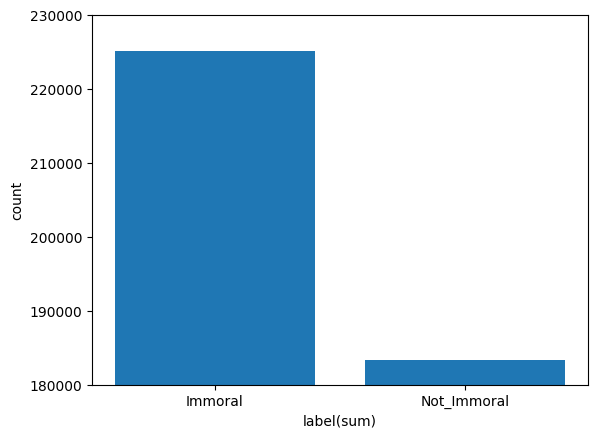

In [ ]:
import matplotlib.pyplot as plt

x = ['Immoral', 'Not_Immoral']
y = df['label'].value_counts()

plt.ylim([180000, 230000])
plt.xlabel('label(sum)')
plt.ylabel('count')
plt.bar(x, y)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(df['text'], df['label'], test_size=0.033, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.035, random_state=0)

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
test_df = pd.DataFrame({'text': X_test, 'label': y_test})
val_df = pd.DataFrame({'text': X_val, 'label': y_val})

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

(293275, 2)
(10637, 2)
(10372, 2)


In [ ]:
binary_ds = DatasetDict({'train': Dataset.from_pandas(train_df), 'val': Dataset.from_pandas(val_df), 'test': Dataset.from_pandas(test_df)})
binary_ds = binary_ds.remove_columns(['__index_level_0__'])
binary_ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 293275
    })
    val: Dataset({
        features: ['text', 'label'],
        num_rows: 10372
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 10637
    })
})

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # CPU or GPU
print(f'Using {device} device...')

model_ckpt = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt, sep_token = '[SEP]', cls_token = '[CLS]')

Using cuda device...


tokenizer_config.json:   0%|          | 0.00/288 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/504 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/450k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
tokenizer.tokenize(binary_ds['train']['text'][0])

['온갖', '세금은', '다', '걷어', '##가네']

In [ ]:
def tokenize_and_encode(data):
    return tokenizer(data['text'],
                     return_tensors = 'pt',
                     padding = True,
                     truncation = True,
                     add_special_tokens = True)

cols = binary_ds['train'].column_names
cols.remove('label')
tokenized_ds = binary_ds.map(tokenize_and_encode, remove_columns=cols)
tokenized_ds

Map:   0%|          | 0/293275 [00:00<?, ? examples/s]

Map:   0%|          | 0/10372 [00:00<?, ? examples/s]

Map:   0%|          | 0/10637 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 293275
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10372
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10637
    })
})

In [ ]:
tokenized_ds['train'][0]

{'label': 0,
 'input_ids': [[2, 9224, 11897, 1347, 14235, 11392, 3]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}

In [ ]:
def flat_input(data):
    return dict(input_ids = sum(data['input_ids'], []))
def flat_token(data):
    return dict(token_type_ids = sum(data['token_type_ids'], []))
def flat_attention(data):
    return dict(attention_mask = sum(data['attention_mask'], []))

final_ds = tokenized_ds.map(flat_input, remove_columns = 'input_ids')
final_ds = final_ds.map(flat_token, remove_columns = 'token_type_ids')
final_ds = final_ds.map(flat_attention, remove_columns = 'attention_mask')
final_ds

Map:   0%|          | 0/293275 [00:00<?, ? examples/s]

Map:   0%|          | 0/10372 [00:00<?, ? examples/s]

Map:   0%|          | 0/10637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293275 [00:00<?, ? examples/s]

Map:   0%|          | 0/10372 [00:00<?, ? examples/s]

Map:   0%|          | 0/10637 [00:00<?, ? examples/s]

Map:   0%|          | 0/293275 [00:00<?, ? examples/s]

Map:   0%|          | 0/10372 [00:00<?, ? examples/s]

Map:   0%|          | 0/10637 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 293275
    })
    val: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10372
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 10637
    })
})

In [ ]:
final_ds.save_to_disk(file_path+'multi_binary_dataset')

Saving the dataset (0/1 shards):   0%|          | 0/293275 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10372 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/10637 [00:00<?, ? examples/s]

In [ ]:
test_df.to_csv(file_path+'multi_binary_testset.csv', encoding = 'utf-8-sig', index = False)